# **Reranking by Altmetric**

In this notebook, I will be investigating the effect of reranking by Altmetric score.  Specifically, I will be retrieving the top 1000 documents by the BM25 weighting model, then removing all documents which do not have an Altmetric score, then reordering to bring the most popular documents to the top.  I will be evaluating this strategy using all the metrics present in round 5 of TREC-COVID, against the baseline BM25 retrieval.

## **Setup**

### **Pyterrier**

In [ ]:
!pip install --upgrade python-terrier

     |████████████████████████████████| 97 kB 3.8 MB/s 
     |████████████████████████████████| 1.1 MB 46.6 MB/s 
     |████████████████████████████████| 69 kB 8.7 MB/s 
     |████████████████████████████████| 255 kB 48.9 MB/s 
     |████████████████████████████████| 41 kB 302 kB/s 
     |████████████████████████████████| 294 kB 44.9 MB/s 
     |████████████████████████████████| 126 kB 44.3 MB/s 
     |████████████████████████████████| 596 kB 42.6 MB/s 
     |████████████████████████████████| 6.4 MB 48.8 MB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
     |████████████████████████████████| 1.2 MB 44.6 MB/s 
     |████████████████████████████████| 291 kB 10.8 MB/s 
     |████████████████████████████████| 59 kB 4.1 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.8.0-py3-none-any.whl size=103883 sha256=334d368ff4192cb7b1266c4f5d652f8e5c5be41a442988d4c0944c9540b1dc1e
  Stored in directory: /root/.cac

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [ ]:
import pandas as pd
from tqdm import tqdm
import gzip
import json

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/round5_index_docs.zip?raw=true
!unzip -u "/content/round5_index_docs.zip?raw=true" -d "/content/index_docs"

--2022-03-15 14:20:45--  https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/round5_index_docs.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/CORD-19_Datasets/round5_index_docs.zip [following]
--2022-03-15 14:20:46--  https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/CORD-19_Datasets/round5_index_docs.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/CORD-19_Datasets/round5_index_docs.zip [following]
--2022-03-15 14:20:46--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/CORD-19_Datasets/round5_index_docs.zip
Resolving raw.githubusercon

In [ ]:
index = pt.IndexFactory.of("/content/index_docs/content/terrier_cord19/data.properties")

In [ ]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = cord19.get_topics('title')

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [9.24MB/s]
/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/round5_docs.csv?raw=true

round5_docs = pd.read_csv('/content/round5_docs.csv?raw=true').drop(columns=['Unnamed: 0'])

--2022-03-15 14:20:53--  https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/round5_docs.csv?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/CORD-19_Datasets/round5_docs.csv [following]
--2022-03-15 14:20:54--  https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/CORD-19_Datasets/round5_docs.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DavidONeill75101/level-4-project/master/Datasets/CORD-19_Datasets/round5_docs.csv [following]
--2022-03-15 14:20:54--  https://media.githubusercontent.com/media/DavidONeill75101/level-4-project/master/Datasets/CORD-19_Datasets/round5_docs.csv
Resolving media.githubusercontent.com (me

### **TREC Datasets**

In [ ]:
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
!wget https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j4.5-5.txt

--2022-03-15 14:21:01--  https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 763591 (746K) [text/plain]
Saving to: ‘qrels-covid_d4_j0.5-4.txt’

qrels-covid_d4_j0.5 100%[===================>] 745.69K   696KB/s    in 1.1s    

2022-03-15 14:21:03 (696 KB/s) - ‘qrels-covid_d4_j0.5-4.txt’ saved [763591/763591]

--2022-03-15 14:21:03--  https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34087 (33K) [text/csv]
Saving to: ‘changedIds-Jul16.csv’

changedIds-Jul16.cs 100%[===================>]  33.29K  --.-KB/s    in 0.07s   

2022-03-15 14:21:03 (455 KB/s) - ‘changedIds-Jul16.csv’ saved 

In [ ]:
import csv

cord_remapping = {}
with open('changedIds-Jul16.csv') as f:
  reader = csv.DictReader(f)
  for row in reader:
    cord_remapping[row['cord_uid_0619']] = row['cord_uid_0716']
len(cord_remapping)

1135

In [ ]:
from collections import Counter,defaultdict

training_judgments_by_topic = defaultdict(dict)
with open('qrels-covid_d4_j0.5-4.txt') as f:
  for line in f:
    topic_id,round_id,doc_id,relevance = line.strip('\n').split()
    topic_id = int(topic_id)
    relevance = int(relevance)
    
    if doc_id in cord_remapping:
      doc_id = cord_remapping[doc_id]

    training_judgments_by_topic[topic_id][doc_id] = relevance


In [ ]:
from collections import defaultdict
qrels = defaultdict(dict)
with open('qrels-covid_d5_j4.5-5.txt') as f:
  for line in f:
    topic_id,iteration,doc_id,judgement = line.strip('\n').split()
    topic_id = int(topic_id)
    judgement = int(judgement)
    qrels[topic_id][doc_id] = judgement

In [ ]:
test_qrels = []
for qid in qrels:
  for docno, judgement in qrels[qid].items():
    test_qrels.append([str(qid), docno, judgement])

test_qrels = pd.DataFrame(test_qrels, columns=['qid', 'docno', 'label'])

### **Altmetric Filtered Index**

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/altmetric_for_CORD-19.json.gz?raw=true

--2022-03-15 14:21:05--  https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/altmetric_for_CORD-19.json.gz?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/CORD-19_Datasets/altmetric_for_CORD-19.json.gz [following]
--2022-03-15 14:21:05--  https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/CORD-19_Datasets/altmetric_for_CORD-19.json.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/CORD-19_Datasets/altmetric_for_CORD-19.json.gz [following]
--2022-03-15 14:21:05--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/CORD-19_Datasets/altmetric_for_COR

In [ ]:
with gzip.open('/content/altmetric_for_CORD-19.json.gz?raw=true', 'r') as f:
  cc = f.read()

  json_str = cc.decode('utf-8')
  data = json.loads(json_str)

In [ ]:
docnos = round5_docs['docno']
altmetrics = []
for docno in docnos:
  if docno in data:
    altmetrics.append(data[docno])
  else:
    altmetrics.append(None)

scores = []

for altmetric in altmetrics:
  if altmetric is not None:
    scores.append(altmetric['score'])
  else:
    scores.append(None)

In [ ]:
round5_docs['altmetric'] = scores

## **Experiments**

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [ ]:
sys_scores = {}

results = []


topic_ids = list(range(1, 51))

for topic_id in tqdm(topic_ids):
  query = topics[topics['qid']==str(topic_id)].iloc[0]['query']
  
  doc_ids_to_exclude = training_judgments_by_topic[topic_id]
  
  result = bm25(query)
   
 
  doc_scores_with_ids = list(zip(result.score,result.docno))
  doc_scores_with_ids = [ (score,doc_id) for score,doc_id in doc_scores_with_ids if not doc_id in doc_ids_to_exclude ]
  doc_scores_with_ids = sorted(doc_scores_with_ids, reverse=True, key=lambda x:x[0])

  sys_scores[topic_id] = doc_scores_with_ids[:1000]

scores = []

for qid in sys_scores:
  rank = 0
  for pair in sys_scores[qid]:
    scores.append([str(qid), pair[1], pair[0], rank])
    rank += 1

bm25_results = pd.DataFrame(scores, columns=['qid', 'docno', 'score', 'rank'])

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
100%|██████████| 50/50 [00:04<00:00, 11.05it/s]


In [ ]:
results = pd.merge(bm25_results, round5_docs).sort_values(by=['qid', 'rank'])
dataframes = []

for i in range(1, 51):
  query_results = results[results['qid']==str(i)]
  
  query_results = query_results[query_results['altmetric'].notnull()].sort_values(by='altmetric', ascending=False)
  query_results['rank'] = list(range(len(query_results)))
  dataframes.append(query_results)

altmetric_results = pd.concat(dataframes)

In [ ]:
altmetric_results

,qid,docno,score,rank,title,doi,date,abstract,altmetric
430,1,27p0hig6,8.520309,0,Global trends in emerging infectious diseases,10.1038/nature06536,2008-02-01,Emerging infectious diseases (EIDs) are a sign...,2223.698
840,1,xcsl2evz,7.818723,1,Isolation of SARS-CoV-2-related coronavirus fr...,10.1038/s41586-020-2313-x,2020-05-07,The outbreak of COVID-19 poses unprecedent cha...,1839.962
57,1,12dcftwt,10.046166,2,Possible Bat Origin of Severe Acute Respirator...,10.3201/eid2607.200092,2020-07-16,We showed that severe acute respiratory syndro...,1741.788
203,1,4k56gviu,9.159515,3,Bats are natural reservoirs of SARS-like coron...,NaN,2005,Severe acute respiratory syndrome (SARS) emerg...,1468.418
1223,1,1gnoo0us,7.340260,4,Smoking Upregulates Angiotensin-Converting Enz...,10.3390/jcm9030841,2020-03-20,The epicenter of the original outbreak in Chin...,1413.922
...,...,...,...,...,...,...,...,...,...
41241,50,vt930bns,13.939230,604,"Dynamic profiles, biodistribution and integrat...",10.1186/s12951-019-0528-5,2019-09-06,"BACKGROUND: The persistence, biodistribution, ...",0.250
41519,50,xd66b7ws,10.542829,605,Coronavirus proteins: biogenesis of avian infe...,NaN,1982,We examined the synthesis of viral structural ...,0.250
41370,50,fp8e7xbm,11.515345,606,The LXR ligand GW3965 inhibits Newcastle disea...,10.1007/s00705-016-2950-4,2016-06-29,Newcastle disease (ND) is a contagious disease...,0.250
3198,50,csgmc155,9.152476,607,The Potency of an Anti-MERS Coronavirus Subuni...,10.3390/vaccines8020251,2020-05-27,Vaccination is one of the most successful stra...,0.250


In [ ]:
from pyterrier.measures import *

eval_results = pt.Experiment([
  bm25_results, 
  altmetric_results
  ],
  topics,
  test_qrels,
  names=["BM25", "Altmetric Reranking"],
  eval_metrics=["ndcg", "ndcg_cut.20", P@20, Bpref, 'map'],
  baseline=0
)

In [ ]:
eval_results

,name,map,Bpref,P@20,ndcg,ndcg_cut.20,map +,map -,map p-value,Bpref +,Bpref -,Bpref p-value,P@20 +,P@20 -,P@20 p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut.20 +,ndcg_cut.20 -,ndcg_cut.20 p-value
0,BM25,0.160014,0.322114,0.490,0.371217,0.465319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Altmetric Reranking,0.086260,0.181408,0.409,0.227361,0.393138,3.0,47.0,8.940818e-11,2.0,48.0,8.526450e-16,10.0,31.0,0.000006,2.0,48.0,1.295646e-17,13.0,34.0,0.000014


In [ ]:
print(eval_results[['name', 'map', 'Bpref', 'P@20', 'ndcg_cut.20', 'map p-value', 'Bpref p-value', 'P@20 p-value', 'ndcg_cut.20 p-value']].to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
               name &      map &    Bpref &  P@20 &  ndcg\_cut.20 &  map p-value &  Bpref p-value &  P@20 p-value &  ndcg\_cut.20 p-value \\
\midrule
               BM25 & 0.160014 & 0.322114 & 0.490 &     0.465319 &          NaN &            NaN &           NaN &                  NaN \\
Altmetric Reranking & 0.086260 & 0.181408 & 0.409 &     0.393138 & 8.940818e-11 &   8.526450e-16 &      0.000006 &             0.000014 \\
\bottomrule
\end{tabular}



## **Results**

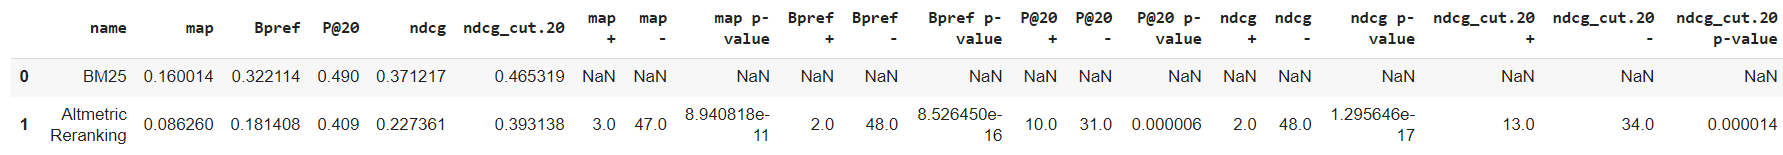